In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [81]:
# ======================== CARGA DE DATOS ======================== #

# Cargar el dataset
file_path = "high_diamond_ranked_10min.csv"
df = pd.read_csv(file_path)

# Eliminar columna irrelevante
df = df.drop(columns=['gameId'])

# Separar características y variable objetivo
X = df.drop(columns=['blueWins'])
y = df['blueWins']

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [82]:
# ======================== MODELO SIN FEATURE SELECTION ======================== #

# Dividir datos en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Definir y entrenar modelo SVM sin selección de características
svm_no_fs = SVC(kernel="rbf", C=10, gamma=0.3)
svm_no_fs.fit(X_train, y_train)

# Evaluar modelo sin feature selection
y_pred_no_fs = svm_no_fs.predict(X_test)
accuracy_no_fs = accuracy_score(y_test, y_pred_no_fs)
f1_no_fs = f1_score(y_test, y_pred_no_fs)

print("\nResultados del modelo SIN feature selection:")
print(f"  - Accuracy: {accuracy_no_fs:.4f}")
print(f"  - F1-score: {f1_no_fs:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_no_fs))


Resultados del modelo SIN feature selection:
  - Accuracy: 0.6898
  - F1-score: 0.6924

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69       983
           1       0.69      0.69      0.69       993

    accuracy                           0.69      1976
   macro avg       0.69      0.69      0.69      1976
weighted avg       0.69      0.69      0.69      1976



In [91]:
# ======================== FEATURE SELECTION ======================== #

## 1. Correlación
correlation = df.corr()["blueWins"].abs().sort_values(ascending=False)
selected_features_corr = correlation[correlation > 0.1].index.tolist()[1:4]  # Evita incluir "blueWins"

## 2. LASSO
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y)
selected_features_lasso = np.array(X.columns)[lasso.coef_ != 0]

## 3. SelectKBest (ANOVA)
k = 10
select_kbest = SelectKBest(score_func=f_classif, k=k)
X_new = select_kbest.fit_transform(X_scaled, y)
selected_features_kbest = np.array(X.columns)[select_kbest.get_support()]

## 4. RFE (Recursive Feature Elimination)
svm_rfe = SVC(kernel="linear")
rfe = RFE(svm_rfe, n_features_to_select=3)  # Seleccionar las 3 mejores características
rfe.fit(X_scaled, y)
selected_features_rfe = np.array(X.columns)[rfe.support_]

In [92]:
# ======================== FUNCIÓN PARA ENTRENAR Y EVALUAR ======================== #

def train_and_evaluate(selected_features, method_name):
    X_selected = X[selected_features]

    # Dividir en train y test
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Escalar
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Entrenar SVM
    svm = SVC(kernel="rbf", C=10, gamma=0.3)
    svm.fit(X_train_scaled, y_train)
    y_pred = svm.predict(X_test_scaled)

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\nResultados con {method_name}:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - F1-score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy, f1, selected_features

In [93]:
# ======================== EJECUCIÓN DE MODELOS ======================== #

accuracy_corr, f1_corr, _ = train_and_evaluate(selected_features_corr, "Correlación")
accuracy_lasso, f1_lasso, _ = train_and_evaluate(selected_features_lasso, "LASSO")
accuracy_kbest, f1_kbest, _ = train_and_evaluate(selected_features_kbest, "SelectKBest")
accuracy_rfe, f1_rfe, selected_features_rfe = train_and_evaluate(selected_features_rfe, "RFE")



Resultados con Correlación:
  - Accuracy: 0.7232
  - F1-score: 0.7222

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       983
           1       0.73      0.72      0.72       993

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


Resultados con LASSO:
  - Accuracy: 0.7050
  - F1-score: 0.7054

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       983
           1       0.71      0.70      0.71       993

    accuracy                           0.70      1976
   macro avg       0.70      0.70      0.70      1976
weighted avg       0.70      0.70      0.70      1976


Resultados con SelectKBest:
  - Accuracy: 0.7196
  - F1-score: 0.7196

Classification Report:
              precision    recall  f1-score   support

           0

In [94]:
# ======================== COMPARACIÓN FINAL ======================== #

# Crear un DataFrame para visualizar los resultados
results_df = pd.DataFrame({
    "Método": ["Sin Feature Selection", "Correlación", "LASSO", "SelectKBest", "RFE"],
    "Accuracy": [accuracy_no_fs, accuracy_corr, accuracy_lasso, accuracy_kbest, accuracy_rfe],
    "F1-score": [f1_no_fs, f1_corr, f1_lasso, f1_kbest, f1_rfe]
})

# Mostrar la tabla de resultados
print("\nResumen de Resultados:")
print(results_df)


Resumen de Resultados:
                  Método  Accuracy  F1-score
0  Sin Feature Selection  0.689777  0.692423
1            Correlación  0.723178  0.722194
2                  LASSO  0.704960  0.705407
3            SelectKBest  0.719636  0.719636
4                    RFE  0.723178  0.722194


<ipython-input-95-e0e723c2ee4c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df["Método"], y=results_df["Accuracy"], palette="Blues")
<ipython-input-95-e0e723c2ee4c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df["Método"], y=results_df["F1-score"], palette="Reds")


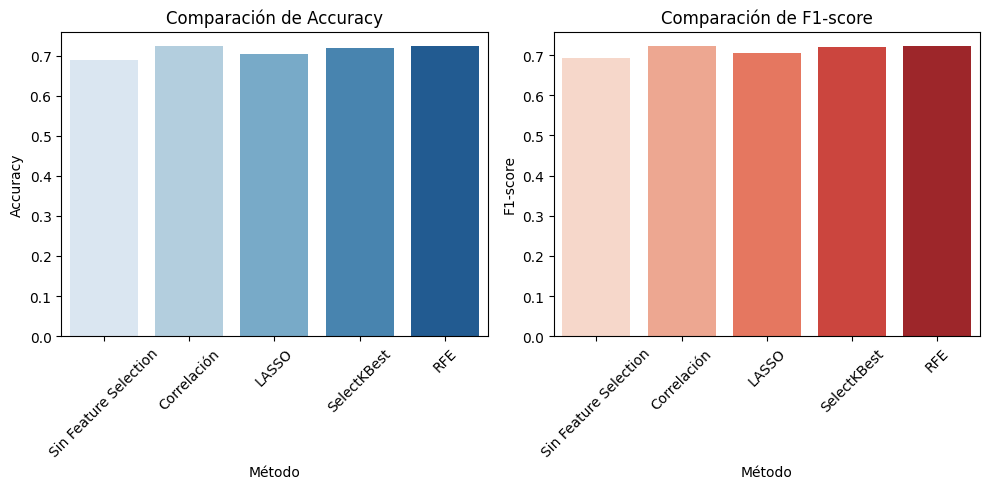

<ipython-input-95-e0e723c2ee4c>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selected_features_rfe, y=rfe.ranking_[rfe.support_], palette="viridis")


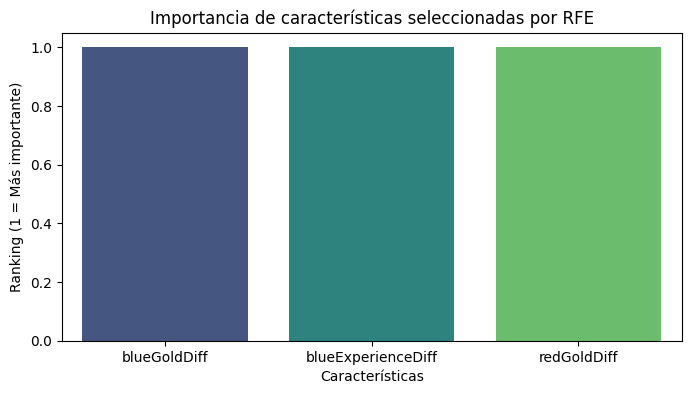

In [95]:
# ======================== GRÁFICAS ======================== #

# Gráfica de comparación de accuracy y F1-score
plt.figure(figsize=(10, 5))

# Accuracy
plt.subplot(1, 2, 1)
sns.barplot(x=results_df["Método"], y=results_df["Accuracy"], palette="Blues")
plt.title("Comparación de Accuracy")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")

# F1-score
plt.subplot(1, 2, 2)
sns.barplot(x=results_df["Método"], y=results_df["F1-score"], palette="Reds")
plt.title("Comparación de F1-score")
plt.xticks(rotation=45)
plt.ylabel("F1-score")

plt.tight_layout()
plt.show()

# Gráfica de importancia de características en RFE
plt.figure(figsize=(8, 4))
sns.barplot(x=selected_features_rfe, y=rfe.ranking_[rfe.support_], palette="viridis")
plt.title("Importancia de características seleccionadas por RFE")
plt.xlabel("Características")
plt.ylabel("Ranking (1 = Más importante)")
plt.show()

# **Respuestas del task 2.2**
#### **Debe definir una métrica de desempeño y justificar el por qué de esta métrica**

La metrica o metricas elegidas fueron el acuraccy y el F1-Score porque son relativamente fáciles de interpretar y en este caso son muy utiles por el hecho que estamos midiendo cuantas predicciones fueron correctas como en este caso serían en cuantas de las partidas que sucedieron ciertas caracteristicas el lado azul ganó. Con el F1-Score también es buena por el hecho de que el set puede estar desbalanceado y toma en cuenta los falsos postivos como los falsos negativos.

### **De las medidas obtenidas, diga qué versión lo hizo mejor y por qué**

En mi caso las que mejor desempeño tuvieron fueron la RFE y la de correlación, estás dos quizás tuvieron mejor desempeño porque una es muy buena encontrando rapidamente las caracteristicas de interes y también eliminando ruido al eliminar variables innecesarias y la otra es iterativa y va encontrando las variables con menos relevancia para nuestra variable objetivo y por ultimo tiende a encontrar el conjunto de caracteristicas más eficiente. En este caso creo que las dos funcionaron muy por la naturaleza del set de datos que y que tiene que ver con que una serie de pasos suceda para que un equipo gane, es un poco más predilecta para correlación y busqueda de caracteristicas que en otros casos como puede ser el reconocer SPAM o imagenes satelitales como vimos en clase.  